# 06.2 - Lazy vs Eager evaluation (or execution)

Python is the example of an __eager__ evaluation language. As soon as you enter a command that bounds a variable to a certain value, that bounding expression is evaluated. Every command gets executed right away.

In a __lazy__ evaluation language, some commands do not trigger memory handling. You can sequence several commands in a row without accessing the data at all. You are actually building a __DAG__(see Class 3, for git, which also builds a DAG) of transformations:

<img src="../Figures/sparkdag.png">

At the end of the DAG, you may trigger an action that will execute all the steps defined by the DAG.

Simply speaking, you are building a recipe. The cooking only begins after you read the entire procedure. We will see more examples of this.

---
## Delayed example

Let's look at a simple example of eager implementation.
Let's define two function that will run in a pipeline. This is a standard example and it is possible you may have already encountered some other very similar example.

In [1]:
from time import sleep

def twice(x):
    sleep(1)
    return 2.0 * x

def mult(x, y):
    sleep(1)
    return x * y

Let's define a data pipeline where we use one function in two occasions and we apply the result as the argument of another function.

In [2]:
%%time
## measures how long this cell takes to compute.

a = twice(2) ## Use function 1, part 1
b = twice(3) ## Use function 1, part 2
z = mult(a, b) ## Get the result of both functions
#print(z)

CPU times: total: 0 ns
Wall time: 3.02 s


But in our multiplication exercise, we can parallelize part of the process: the __twice__ operations are independent, thus they can be parallelized.

We will use the decorator `delayed` for this task. A **decorator** in python is a function that takes another function as its argument and __returns another function__.

In [3]:
from dask import delayed

In [4]:
%%time
a = delayed(twice)(2)
b = delayed(twice)(3)
z = delayed(mult)(a, b)

CPU times: total: 0 ns
Wall time: 0 ns


The previous action took virtually no time. This is because we have yet to execute the computation proper. We need to **compute** the computation. So far, we have loaded a **DAG** of computations into **z**.

In [5]:
%%time
##Compute it now

z.compute()

CPU times: total: 0 ns
Wall time: 2.01 s


24.0

In [6]:
z

Delayed('mult-b0fbb10c-40d3-467a-82b1-a4a12534b56e')

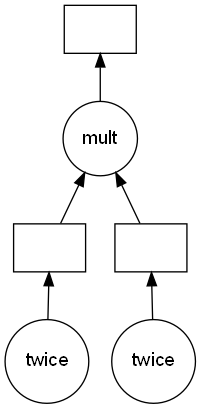

In [7]:
z.visualize()

Some questions:
1. Why 2s instead of 3s?
1. Can we bring the time down to 1s?

Answers:
The two questions are interlinked. The `mult` function has a dependency on the `twice` function. It is only after all instances of `twice` are finished that dask procedes to compute `mult`. Hence, the theoretical minimal time is 2s.

---
## Let's build a more ambitious DAG

In [8]:
def add(x, y):
    sleep(1)
    return x + y

In [9]:
%%time
a = delayed(twice)(2)
b = delayed(twice)(3)
c = delayed(add)(a, b)
d = delayed(mult)(a, c)
z = delayed(mult)(c, d)

CPU times: total: 0 ns
Wall time: 995 µs


<div class="alert alert-info"> 
    <br>
    <b>Exercise: Can you guess how long will the computation will take without doing the computation?</b>   
    <br>
    <br>
</div>

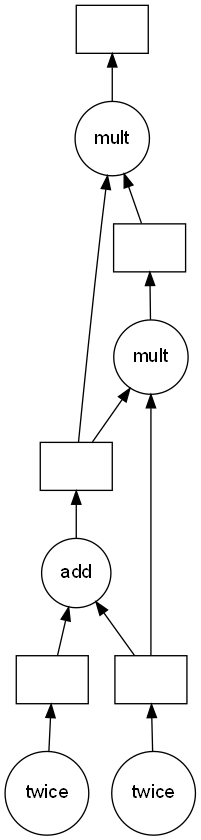

In [10]:
z.visualize()

In [11]:
%%time
z.compute()

CPU times: total: 0 ns
Wall time: 4.02 s


400.0

We saved just one second because there is only two operations being done simultaneously.

---
### Loops

Let's look at how to parallelize loops. If all the iterations of a loop are independent, you can safely parallelize your code.

In [12]:
%%time

elements = []

for i in range(10):
    y = delayed(add)(1, i)
    elements.append(y)
    
total = delayed(sum)(elements)

CPU times: total: 0 ns
Wall time: 997 µs


How can we see the structure of what we did?  
Remember, `total` is a `Delayed` object, so it has a visualize method.

In [13]:
total

Delayed('sum-ecf1b01b-08a7-4bb2-aabe-6e480594f893')

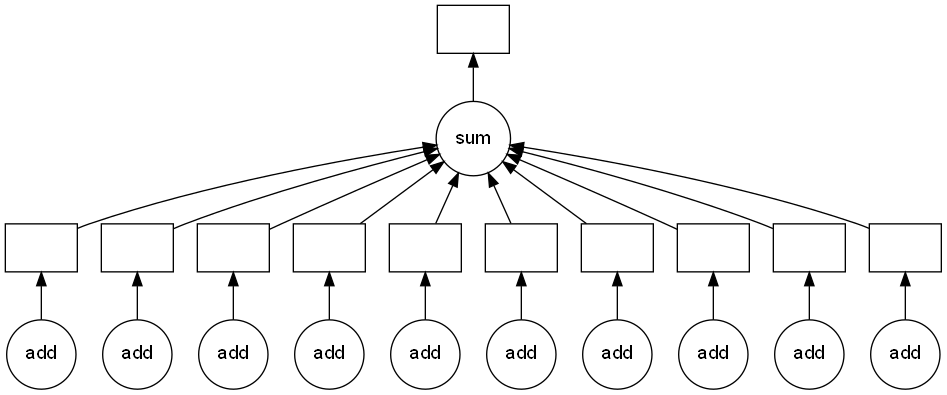

In [14]:
total.visualize()

You will make 10 calls to the user defined `add` function in parallel and then finally use the default `sum` function.

The latter has no sleep, so it will be executed as fast as possible.

If we now compute, we see it takes a little over one second to run. Is it also one second in your machine?

In [15]:
%%time

elements = []

for i in range(10):
    y = delayed(add)(1, i)
    elements.append(y)
    
total = delayed(sum)(elements)

total.compute()

CPU times: total: 0 ns
Wall time: 1.01 s


55

In [16]:
%%time

elements = []

for i in range(10):
    y = add(1, i)
    elements.append(y)
    
total = sum(elements)
total
#total.compute()

CPU times: total: 0 ns
Wall time: 10.1 s


55